In [1]:



# Create directories for saving data and weights
!mkdir save_data5
!mkdir weights5

In [2]:
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import time
import tensorflow

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

%matplotlib inline

In [3]:
import os
import numpy as np
from imageio import imread  

def loadimgs(path, n=0):

    X = []
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    # Load every alphabet separately
    for alphabet in os.listdir(path):
        print(f"Loading alphabet: {alphabet}")
        lang_dict[alphabet] = [curr_y, None]
        alphabet_path = os.path.join(path, alphabet)

        # Check if alphabet path is a directory
        if not os.path.isdir(alphabet_path):
            print(f"Skipping non-directory: {alphabet_path}")
            continue
        
        # Load letters within each alphabet
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)

            # Check if letter path is a directory
            if not os.path.isdir(letter_path):
                print(f"Skipping non-directory: {letter_path}")
                continue
            
            # Read all images in the current letter category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)

                try:
                    image = imread(image_path)
                    category_images.append(image)
                    y.append(curr_y)
                except Exception as e:
                    print(f"Error reading {image_path}: {e}")

            # Stack images for the current category
            if category_images:  # Check if there are any images to stack
                try:
                    X.append(np.stack(category_images))
                except ValueError as e:
                    print(f"Error stacking images for category {cat_dict[curr_y]}: {e}")
                    print("Category images:", category_images)

            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1

    y = np.array(y)  # Convert list to numpy array
    X = np.array(X)  # Convert list of arrays to numpy array
    return X, y, lang_dict


In [4]:
train_folder = '/kaggle/input/daata-cv/images_background/images_background'
valid_folder = '/kaggle/input/daata-cv/images_evaluation/images_evaluation'
save_path = '/kaggle/working/save_data5'
model_path = '/kaggle/working/weights5'

In [5]:
X, y, c = loadimgs(train_folder)
X.shape, y.shape

Loading alphabet: Grantha


/tmp/ipykernel_30/3505650807.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


Loading alphabet: Armenian
Loading alphabet: Greek
Loading alphabet: Syriac_(Estrangelo)
Loading alphabet: Latin
Loading alphabet: Mkhedruli_(Georgian)
Loading alphabet: Futurama
Loading alphabet: Bengali
Loading alphabet: Gujarati
Loading alphabet: Alphabet_of_the_Magi
Loading alphabet: Cyrillic
Loading alphabet: Malay_(Jawi_-_Arabic)
Loading alphabet: N_Ko
Loading alphabet: Korean
Loading alphabet: Burmese_(Myanmar)
Loading alphabet: Tifinagh
Loading alphabet: Asomtavruli_(Georgian)
Loading alphabet: Arcadian
Loading alphabet: Balinese
Loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Tagalog
Loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Japanese_(katakana)
Loading alphabet: Japanese_(hiragana)
Loading alphabet: Anglo-Saxon_Futhorc
Loading alphabet: Braille
Loading alphabet: Sanskrit
Loading alphabet: Hebrew
Loading alphabet: Early_Aramaic


((964, 20, 105, 105), (19280,))

In [6]:
c.keys()

dict_keys(['Grantha', 'Armenian', 'Greek', 'Syriac_(Estrangelo)', 'Latin', 'Mkhedruli_(Georgian)', 'Futurama', 'Bengali', 'Gujarati', 'Alphabet_of_the_Magi', 'Cyrillic', 'Malay_(Jawi_-_Arabic)', 'N_Ko', 'Korean', 'Burmese_(Myanmar)', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Arcadian', 'Balinese', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Tagalog', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Japanese_(hiragana)', 'Anglo-Saxon_Futhorc', 'Braille', 'Sanskrit', 'Hebrew', 'Early_Aramaic'])

In [7]:
c['Bengali'], c['Gujarati']

([224, 269], [270, 317])

In [8]:
X_val, y_val, c_val=loadimgs(valid_folder)
X_val.shape, y_val.shape

Loading alphabet: Sylheti


/tmp/ipykernel_30/3505650807.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


Loading alphabet: Keble
Loading alphabet: Atemayar_Qelisayer
Loading alphabet: Tibetan
Loading alphabet: Aurek-Besh
Loading alphabet: Ge_ez
Loading alphabet: Glagolitic
Loading alphabet: Oriya
Loading alphabet: Gurmukhi
Loading alphabet: Mongolian
Loading alphabet: Kannada
Loading alphabet: Syriac_(Serto)
Loading alphabet: Manipuri
Loading alphabet: ULOG
Loading alphabet: Old_Church_Slavonic_(Cyrillic)
Loading alphabet: Atlantean
Loading alphabet: Angelic
Loading alphabet: Tengwar
Loading alphabet: Avesta
Loading alphabet: Malayalam


((659, 20, 105, 105), (13180,))

In [9]:
c_val.keys()

dict_keys(['Sylheti', 'Keble', 'Atemayar_Qelisayer', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Glagolitic', 'Oriya', 'Gurmukhi', 'Mongolian', 'Kannada', 'Syriac_(Serto)', 'Manipuri', 'ULOG', 'Old_Church_Slavonic_(Cyrillic)', 'Atlantean', 'Angelic', 'Tengwar', 'Avesta', 'Malayalam'])

In [10]:
# Load the images
X, y, lang_dict = loadimgs(train_folder)

# Save training data
with open(os.path.join(save_path, "train2.pickle"), "wb") as f:
    pickle.dump((X, y, lang_dict), f)

# Load validation images
X_val, y_val, lang_dict_val = loadimgs(valid_folder)

# Save validation data
with open(os.path.join(save_path, "val2.pickle"), "wb") as f:
    pickle.dump((X_val, y_val, lang_dict_val), f)


Loading alphabet: Grantha


/tmp/ipykernel_30/3505650807.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


Loading alphabet: Armenian
Loading alphabet: Greek
Loading alphabet: Syriac_(Estrangelo)
Loading alphabet: Latin
Loading alphabet: Mkhedruli_(Georgian)
Loading alphabet: Futurama
Loading alphabet: Bengali
Loading alphabet: Gujarati
Loading alphabet: Alphabet_of_the_Magi
Loading alphabet: Cyrillic
Loading alphabet: Malay_(Jawi_-_Arabic)
Loading alphabet: N_Ko
Loading alphabet: Korean
Loading alphabet: Burmese_(Myanmar)
Loading alphabet: Tifinagh
Loading alphabet: Asomtavruli_(Georgian)
Loading alphabet: Arcadian
Loading alphabet: Balinese
Loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Tagalog
Loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
Loading alphabet: Japanese_(katakana)
Loading alphabet: Japanese_(hiragana)
Loading alphabet: Anglo-Saxon_Futhorc
Loading alphabet: Braille
Loading alphabet: Sanskrit
Loading alphabet: Hebrew
Loading alphabet: Early_Aramaic
Loading alphabet: Sylheti
Loa

In [11]:
print(os.listdir(save_path))



['train2.pickle', 'val2.pickle']


In [12]:
# Load the training data
with open(os.path.join(save_path, "train2.pickle"), "rb") as f:
    (X_train, train_classes, lang_dict) = pickle.load(f)

print("Training alphabets: \n")
print(list(lang_dict.keys()))  # This should now correctly print the keys of your class dictionary

# Load the validation data
with open(os.path.join(save_path, "val2.pickle"), "rb") as f:
    (X_val, val_classes, lang_dict_val) = pickle.load(f)

print("\n\n\nValidation alphabets: \n")
print(list(lang_dict_val.keys()))  # This should now correctly print the keys of your validation class dictionary


Training alphabets: 

['Grantha', 'Armenian', 'Greek', 'Syriac_(Estrangelo)', 'Latin', 'Mkhedruli_(Georgian)', 'Futurama', 'Bengali', 'Gujarati', 'Alphabet_of_the_Magi', 'Cyrillic', 'Malay_(Jawi_-_Arabic)', 'N_Ko', 'Korean', 'Burmese_(Myanmar)', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Arcadian', 'Balinese', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Tagalog', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Japanese_(hiragana)', 'Anglo-Saxon_Futhorc', 'Braille', 'Sanskrit', 'Hebrew', 'Early_Aramaic']



Validation alphabets: 

['Sylheti', 'Keble', 'Atemayar_Qelisayer', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Glagolitic', 'Oriya', 'Gurmukhi', 'Mongolian', 'Kannada', 'Syriac_(Serto)', 'Manipuri', 'ULOG', 'Old_Church_Slavonic_(Cyrillic)', 'Atlantean', 'Angelic', 'Tengwar', 'Avesta', 'Malayalam']


In [13]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [14]:
def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [15]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [16]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)
    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
        
    return pairs, targets


def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... ".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        
    return percent_correct

In [17]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [18]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K

# Initialize your weight and bias initializers (W_init and b_init)
W_init = 'he_normal'  # Example; you can change as needed
b_init = 'zeros'      # Example; you can change as needed

def create_siamese_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                       kernel_initializer=W_init, kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (7, 7), activation='relu',
                       kernel_regularizer=l2(2e-4), kernel_initializer=W_init, bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3), kernel_initializer=W_init, bias_initializer=b_init))
    
    # Encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
    # Merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]),
                      output_shape=(4096,))  # Specify the output shape
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # Compile the model
    optimizer = Adam(0.0001)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return siamese_net

# Create the model instance
model_instance = create_siamese_model()

# Check the model summary
model_instance.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 38,947,648 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import os
print(os.getcwd())


/kaggle/working


In [20]:
import pydot
import graphviz
from keras.utils import plot_model

# Test if Graphviz and pydot are working
try:
    dot_data = 'digraph G {Hello->World}'
    graph = graphviz.Source(dot_data)
    graph.render('test-output/graph')  # Saves as 'test-output/graph.pdf'
    print("Graphviz and pydot are working!")
except Exception as e:
    print("Graphviz or pydot is not working:", e)


Graphviz and pydot are working!


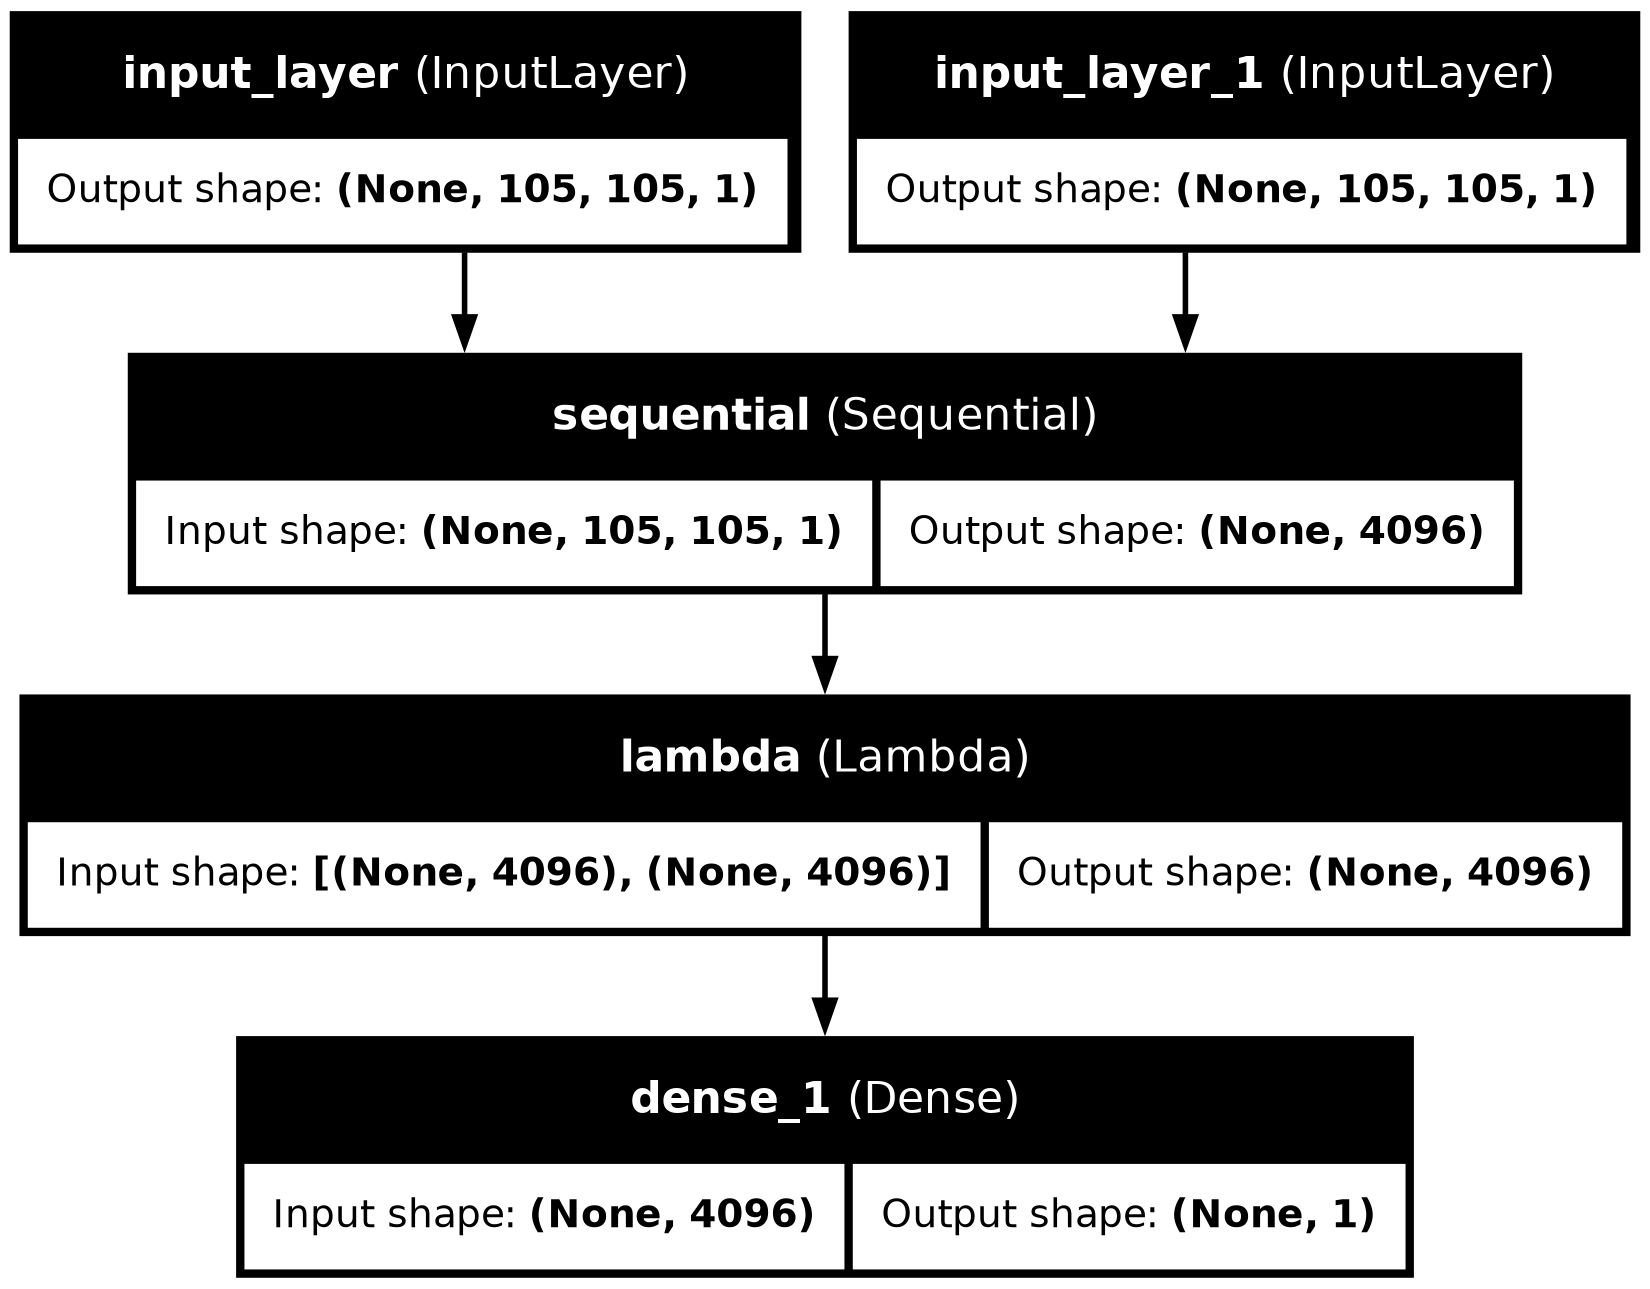

In [21]:
from keras.utils import plot_model
from IPython.display import Image, display
import os

# Define the file path
output_image_path = 'model.png'

# Visualize the model
plot_model(model_instance, to_file=output_image_path, show_shapes=True, show_layer_names=True)

# Display the saved image
if os.path.exists(output_image_path):
    display(Image(output_image_path))
else:
    print("Failed to save the model plot.")


In [22]:
# Assuming 'model_instance' is your trained Keras model
model_file_path = os.path.join(model_path, 'model.h5')

# Save the entire model to an H5 file
model_instance.save(model_file_path)
print(f"Model saved to {model_file_path}")


Model saved to /kaggle/working/weights5/model.h5


In [23]:
import time


In [24]:
import tensorflow as tf  # Add this import statement at the top
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
import os
import time
import json

# Initialize your weight and bias initializers (W_init and b_init)
W_init = 'he_normal'  
b_init = 'zeros'      

def create_siamese_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                       kernel_initializer=W_init, kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (7, 7), activation='relu',
                       kernel_regularizer=l2(2e-4), kernel_initializer=W_init, bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3), kernel_initializer=W_init, bias_initializer=b_init))
    
    # Encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
    # Merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]),
                      output_shape=(4096,))  # Specify the output shape
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # Compile the model
    optimizer = Adam(0.0001)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return siamese_net

# Create the model instance
model_instance = create_siamese_model()

# Check the model summary
model_instance.summary()

# Ensure model_path exists
model_path = "model_weights"
os.makedirs(model_path, exist_ok=True)  # Create directory if it doesn't exist

# Define the training function
def training_starts(model_instance, evaluate_every=250, batch_size=32, n_iter=600, N_way=20, n_val=250):
    '''
    Hyper parameters
    
    evaluate_every : interval for evaluating on one-shot tasks
    batch_size : batch size
    n_iter : No. of training iterations
    N_way : how many classes for testing one-shot tasks
    n_val : how many one-shot tasks to validate on
    '''
    
    print("Starting training process!")
    print("-------------------------------------")
    best = -1
    t_start = time.time()  # Start timer for the entire training process
    
    for i in range(1, n_iter + 1):
        iteration_start = time.time()  # Start timer for the current iteration
        (inputs, targets) = get_batch(batch_size)
        loss = model_instance.train_on_batch(inputs, targets)  # Use model_instance here
        
        # Calculate time taken for the current iteration
        iteration_time = time.time() - iteration_start  # Time for this iteration
        
        # Print detailed iteration-wise progress
        print(f"Iteration {i}/{n_iter} - Loss: {loss:.4f} - Time: {iteration_time:.2f} seconds")
        
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1:.2f} mins".format(i, (time.time() - t_start) / 60.0))
            print("Train Loss: {0}".format(loss)) 
            val_acc = test_oneshot(model_instance, N_way, n_val, verbose=True)  # Use model_instance
            
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                # Save weights with the iteration number
                model_instance.save_weights(os.path.join(model_path, 'weights_iter_{}.weights.h5'.format(i)))  
                best = val_acc
                
                # Save model architecture to JSON
                model_json = model_instance.to_json()
                with open(os.path.join(model_path, 'model.json'), 'w') as json_file:
                    json.dump(model_json, json_file)

    # Save the entire model to an H5 file after training
    model_file_path = os.path.join(model_path, 'model.h5')
    model_instance.save(model_file_path)
    print(f"Model saved to {model_file_path}")

    print("-------------------------------------")
    print("Total training time: {:.2f} minutes.".format((time.time() - t_start) / 60.0))

# Example call to the training function
training_starts(model_instance)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4096)      │ 38,947,648 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 4096)      │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

Starting training process!
-------------------------------------


I0000 00:00:1730018849.337041     109 service.cc:145] XLA service 0x7844c4006070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730018849.337108     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730018849.337112     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730018865.374271     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration 1/600 - Loss: 9.1277 - Time: 18.92 seconds
Iteration 2/600 - Loss: 9.1005 - Time: 0.45 seconds
Iteration 3/600 - Loss: 9.1025 - Time: 0.47 seconds
Iteration 4/600 - Loss: 9.0930 - Time: 0.47 seconds
Iteration 5/600 - Loss: 9.0841 - Time: 0.47 seconds
Iteration 6/600 - Loss: 9.0707 - Time: 0.47 seconds
Iteration 7/600 - Loss: 9.0506 - Time: 0.49 seconds
Iteration 8/600 - Loss: 9.0344 - Time: 0.47 seconds
Iteration 9/600 - Loss: 9.0214 - Time: 0.47 seconds
Iteration 10/600 - Loss: 9.0092 - Time: 0.47 seconds
Iteration 11/600 - Loss: 8.9917 - Time: 0.47 seconds
Iteration 12/600 - Loss: 8.9806 - Time: 0.47 seconds
Iteration 13/600 - Loss: 8.9677 - Time: 0.47 seconds
Iteration 14/600 - Loss: 8.9529 - Time: 0.47 seconds
Iteration 15/600 - Loss: 8.9409 - Time: 0.47 seconds
Iteration 16/600 - Loss: 8.9257 - Time: 0.48 seconds
Iteration 17/600 - Loss: 8.9111 - Time: 0.47 seconds
Iteration 18/600 - Loss: 8.8982 - Time: 0.47 seconds
Iteration 19/600 - Loss: 8.8838 - Time: 0.47 seconds
I

In [25]:
model_instance.compile(loss="binary_crossentropy", optimizer=Adam(0.00001))

In [26]:
training_starts(model_instance)

Starting training process!
-------------------------------------
Iteration 1/600 - Loss: 2.2247 - Time: 11.22 seconds
Iteration 2/600 - Loss: 2.2233 - Time: 0.73 seconds
Iteration 3/600 - Loss: 2.2221 - Time: 0.71 seconds
Iteration 4/600 - Loss: 2.2212 - Time: 0.71 seconds
Iteration 5/600 - Loss: 2.2203 - Time: 0.67 seconds
Iteration 6/600 - Loss: 2.2191 - Time: 0.70 seconds
Iteration 7/600 - Loss: 2.2180 - Time: 0.71 seconds
Iteration 8/600 - Loss: 2.2169 - Time: 0.69 seconds
Iteration 9/600 - Loss: 2.2159 - Time: 0.69 seconds
Iteration 10/600 - Loss: 2.2147 - Time: 0.68 seconds
Iteration 11/600 - Loss: 2.2138 - Time: 0.67 seconds
Iteration 12/600 - Loss: 2.2126 - Time: 0.68 seconds
Iteration 13/600 - Loss: 2.2115 - Time: 0.68 seconds
Iteration 14/600 - Loss: 2.2104 - Time: 0.66 seconds
Iteration 15/600 - Loss: 2.2092 - Time: 0.64 seconds
Iteration 16/600 - Loss: 2.2080 - Time: 0.64 seconds
Iteration 17/600 - Loss: 2.2068 - Time: 0.63 seconds
Iteration 18/600 - Loss: 2.2057 - Time: 0.

In [25]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [26]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [27]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model_instance, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model_instance, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-----------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━

/tmp/ipykernel_30/2008305976.py:6: RuntimeWarning: invalid value encountered in sqrt
  L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [28]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
    
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [29]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [30]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Function to create MobileNet model with transfer learning
def create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=30, weights_path=None):
    base_model = MobileNet(weights=weights_path, include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Path to your local MobileNet weights file
weights_path = '/kaggle/input/mobile/mobilenet_1_0_128_tf_no_top.h5'  # Update with actual path

# Number of classes
num_classes = 30  # Adjust this based on your dataset
mobilenet_model = create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=num_classes, weights_path=weights_path)

# Compile the model
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/daata-cv/images_background/images_background',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 19280 images belonging to 30 classes.


In [36]:
# Train the model and capture accuracy for MobileNet
history = mobilenet_model.fit(train_generator, epochs=10, verbose=1)
mobilenet_accs = history.history['accuracy']
# Optionally save the model or its weights to avoid retraining
mobilenet_model.save('/kaggle/working/mobilenet_model.h5')


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.8611 - loss: 0.4674
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8653 - loss: 0.4491
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8679 - loss: 0.4443
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8795 - loss: 0.4118
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8863 - loss: 0.3930
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8910 - loss: 0.3780
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8874 - loss: 0.3749
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8943 - loss: 0.3643
Epoch 9/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8960 - loss: 0.3491
Epoch 10/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9023 - loss: 0.3383


In [ ]:
# Define arrays to store accuracy values
ways = np.arange(1, 20, 2)
trials = 50
val_accs, train_accs, nn_accs, mobilenet_task_accs = [], [], [], []

# Iterate over different "ways" and collect accuracies
for N in ways:
    # Siamese Network Accuracies (Validation and Training)
    val_acc = test_oneshot(model_instance, N, trials, "val", verbose=True)
    train_acc = test_oneshot(model_instance, N, trials, "train", verbose=True)
    val_accs.append(val_acc)
    train_accs.append(train_acc)

    # Nearest Neighbour Accuracy
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)

    # Average MobileNet accuracy for each trial (already computed)
    mobilenet_task_accs.append(np.mean(mobilenet_accs) * 100)  # Convert to percentage

# Save accuracies to avoid recomputation
np.savez('/kaggle/working/one_shot_accuracies.npz', ways=ways, val_accs=val_accs, train_accs=train_accs, nn_accs=nn_accs, mobilenet_task_accs=mobilenet_task_accs)


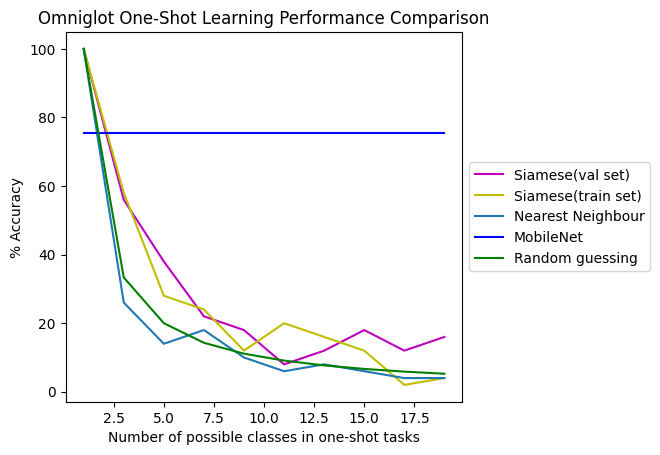

In [39]:
import matplotlib.pyplot as plt

# Load previously saved accuracies
data = np.load('/kaggle/working/one_shot_accuracies.npz')
ways = data['ways']
val_accs = data['val_accs']
train_accs = data['train_accs']
nn_accs = data['nn_accs']
mobilenet_task_accs = data['mobilenet_task_accs']

# Plot results
fig, ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
ax.plot(ways, nn_accs, label="Nearest Neighbour")
ax.plot(ways, mobilenet_task_accs, "b", label="MobileNet")
ax.plot(ways, 100.0 / ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omniglot One-Shot Learning Performance Comparison")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Load previously saved accuracies
data = np.load('/kaggle/working/one_shot_accuracies.npz')
ways = data['ways']
val_accs = data['val_accs']
train_accs = data['train_accs']
nn_accs = data['nn_accs']
mobilenet_task_accs = data['mobilenet_task_accs']

# Plot results
fig, ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
ax.plot(ways, nn_accs, label="Nearest Neighbour")
ax.plot(ways, mobilenet_task_accs, "b", label="MobileNet")
ax.plot(ways, 100.0 / ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omniglot One-Shot Learning Performance Comparison")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the VGG16 model from scratch
def vgg16(input_shape=(105, 105, 1), num_classes=50):
    inputs = layers.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 5
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Function to load and preprocess data
def load_data(train_dir, val_dir, img_size=(105, 105), batch_size=32):
    # Image data generator for training and validation
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    val_datagen = ImageDataGenerator(rescale=1./255)

    # Load data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator

# Paths to your data
train_dir = '/kaggle/input/daata-cv/images_background/images_background'
valid_dir = '/kaggle/input/daata-cv/images_evaluation/images_evaluation'

# Load data
train_generator, val_generator = load_data(train_dir, valid_dir, img_size=(224, 224), batch_size=32)

# Create VGG16 model
num_classes = len(train_generator.class_indices)  # Automatically get number of classes from generator
model = vgg16(input_shape=(224, 224, 3), num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10  # You can change the number of epochs as needed
)

# Save the model
model.save('vgg16_model.h5')


Found 19280 images belonging to 30 classes.
Found 13180 images belonging to 20 classes.


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │       122,91

 Total params: 134,383,454 (512.63 MB)

 Trainable params: 134,383,454 (512.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
411/602 ━━━━━━━━━━━━━━━━━━━━ 1:43 541ms/step - accuracy: 0.0510 - loss: 3.6357


KeyboardInterrupt



In [ ]:
import os
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create MobileNet model with transfer learning
def create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=50, weights_path=None):
    # Load MobileNet with local weights
    base_model = MobileNet(weights=weights_path, include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers to prevent them from being trained
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add fully connected layer with the number of classes
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Path to your local MobileNet weights file
weights_path = '/kaggle/input/mobile/mobilenet_1_0_128_tf_no_top.h5'  # Update with actual path

# ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/daata-cv/images_background/images_background',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Create the MobileNet model
num_classes = len(train_generator.class_indices)  # Automatically get the number of classes from generator
model = create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=num_classes, weights_path=weights_path)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture the history object
history = model.fit(train_generator, epochs=10)

# Now you can access the accuracy history
train_accs = history.history['accuracy']  # Training accuracy for each epoch

# Print the training accuracy for each epoch
print("Training Accuracies: ", train_accs)



In [ ]:
model.save('mobilenet_model.h5')  # Save the model in HDF5 format


In [ ]:
# Your existing plot code
fig, ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

# Plot for MobileNet
ax.plot(ways, mobilenet_train_accs, "b", label="MobileNet(train set)")


# Random guessing plot
ax.plot(ways, 100.0/ways, "g", label="Random guessing")

# Axis labels, title, and legend positioning
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("One-Shot Learning Performance of Multiple Networks")

# Adjust the legend box
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()


In [44]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Function to create MobileNet model with transfer learning
def create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=30, weights_path=None):
    base_model = MobileNet(weights=weights_path, include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Path to your local MobileNet weights file
weights_path = '/kaggle/input/mobile/mobilenet_1_0_128_tf_no_top.h5'  # Update with actual path

# Number of classes
num_classes = 30  # Adjust this based on your dataset
mobilenet_model = create_mobilenet_transfer(input_shape=(128, 128, 3), num_classes=num_classes, weights_path=weights_path)

# Compile the model
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/daata-cv/images_background/images_background',  # Update this path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/mobilenet-val/images_evaluation',  # Update this path to your validation data
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 19280 images belonging to 30 classes.
Found 25700 images belonging to 30 classes.


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess_images(image_paths, target_size=(224, 224)):
    
    processed_images = []

    for img_path in image_paths:
        # Load the image with target size
        image = load_img(img_path, target_size=target_size)
        
        # Convert the image to an array
        image_array = img_to_array(image)
        
        # Ensure the image has 3 channels (RGB)
        if image_array.shape[-1] == 1:  # If it's grayscale
            image_array = np.stack((image_array,)*3, axis=-1)

        # Add batch dimension (1, height, width, channels)
        image_array = np.expand_dims(image_array, axis=0)
        
        # Preprocess the image
        image_array = preprocess_input(image_array)
        
        # Append the processed image to the list
        processed_images.append(image_array)

    # Stack the processed images into a single numpy array
    return np.vstack(processed_images)

# Example usage
image_folder = '/kaggle/input/daata-cv/images_background'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
preprocessed_images = preprocess_images(image_paths)

# Now you can use `preprocessed_images` for prediction with EfficientNet
print(preprocessed_images.shape)  # Check the shape of the preprocessed images


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import os
import pickle

# Load ResNet model and remove the top layer for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_embedding(image):
    """
    Extracts the feature embedding of an image using ResNet.

    Parameters:
        image (np.ndarray): Input image of any size.

    Returns:
        np.ndarray: Feature embedding vector.
    """
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    embedding = model.predict(image)
    return embedding.flatten()

def nearest_resnet_correct(pairs, targets):
    """
    Returns 1 if ResNet nearest neighbor gets the correct answer for a one-shot task.

    Parameters:
        pairs (tuple): Tuple of reference and candidate images.
        targets (np.ndarray): Ground truth for matching.

    Returns:
        int: 1 if ResNet finds the correct nearest match, 0 otherwise.
    """
    resnet_distances = np.zeros_like(targets, dtype=np.float32)

    for i in range(len(targets)):
        ref_img = pairs[0][i]
        cand_img = pairs[1][i]

        # Extract embeddings for both reference and candidate images
        ref_embedding = extract_embedding(ref_img)
        cand_embedding = extract_embedding(cand_img)

        # Calculate Euclidean distance between embeddings
        resnet_distances[i] = np.linalg.norm(ref_embedding - cand_embedding)

    # Check if the minimum distance index corresponds to the correct target
    if np.argmin(resnet_distances) == np.argmax(targets):
        return 1
    return 0

def test_resnet_accuracy(N_ways, n_trials):
    """
    Returns accuracy of ResNet approach for one-shot tasks.

    Parameters:
        N_ways (int): Number of classes for one-shot task.
        n_trials (int): Number of trials.

    Returns:
        float: ResNet accuracy in percentage.
    """
    print(f"Evaluating ResNet on {n_trials} unique {N_ways}-way one-shot learning tasks...")

    n_correct = 0
    for _ in range(n_trials):
        pairs, targets = make_oneshot_task(N_ways, "val")
        correct = nearest_resnet_correct(pairs, targets)
        n_correct += correct

    return 100.0 * n_correct / n_trials

# Run ResNet-based one-shot learning accuracy test
ways = np.arange(1, 20, 2)
trials = 50
val_accs, train_accs, resnet_accs = [], [], []

for N in ways:    
    val_accs.append(test_oneshot(model_instance, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model_instance, N, trials, "train", verbose=True))
    resnet_acc = test_resnet_accuracy(N, trials)
    resnet_accs.append(resnet_acc)
    print("ResNet Accuracy =", resnet_acc)
    print("-----------------------------------------------------------------------------------")

# Save accuracies
save_path = 'path/to/save'
with open(os.path.join(save_path, "resnet_accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs, train_accs, resnet_accs), f)

def concat_images(X):
    """Concatenates a batch of images into a single matrix for plotting."""
    nc, h, w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n * w, n * h))
    x, y = 0, 0
    for example in range(nc):
        img[x * w:(x + 1) * w, y * h:(y + 1) * h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Plots a one-shot task with reference and candidate images."""
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(224, 224), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Load and display results
with open(os.path.join(save_path, "resnet_accuracies.pickle"), "rb") as f:
    val_accs, train_accs, resnet_accs = pickle.load(f)
